Objectifs : 

- regarder le chant initial (fichier wav, deriv spec, score pour chaque feature)

- regarder le chant de Boari (fichier wav, deriv spec, score pour chaque feature)

- Q: Pourquoi le chant initial a une erreur plus faible que celle de Boari ?


# Imports

In [1]:
# Fixed plots
%matplotlib inline
# Dynamic plots
# %matplotlib notebook

import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import sys
import math

import birdsonganalysis as bsa
import utils

sys.path.append('../model/')
from synth import synthesize
from measures import bsa_measure
from song_model import SongModel

np.set_printoptions(precision=3)

# Function and variable definitions

In [2]:
# Taken from the GridAnalyser object from birdsonglearningmodel/analysis/utils.py
def boari_synth_song_error(tutor_song, synth_song, p_coefs):
    """
    Calculate the error between the Boari synthezised song
    and the tutor song
    Calculate only on sung parts, ignore the silence parts with
    the threshold
    """
    amp = bsa.song_amplitude(synth_song, 256, 40, 1024)
    sort_amp = np.sort(amp)
    sort_amp = sort_amp[len(sort_amp)//10:]
    i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
    threshold = sort_amp[i_max_diff]
    
    msynth = bsa_measure(synth, 44100, coefs=p_coefs)
    mtutor = bsa_measure(tutor, 44100, coefs=p_coefs)
    
    score = np.linalg.norm(msynth[amp > threshold] - mtutor[amp > threshold]) / np.sum(amp > threshold) * len(amp)
    
    return score

In [3]:
# g and c are outputs from the bsa_measure function
error_measure = lambda g, c: np.linalg.norm(g - c)

In [4]:
# Generation of the 3 songs: tutor, synthesized, initial song from the model
song_name = "boari_short"

# tutor not normalized, int16 (-32768 to 32767) format
sr, tutor = wavfile.read('../data/{}.wav'.format(song_name))
# synth is already NORMALIZED
sr, synth = wavfile.read('../data/{}_out.wav'.format(song_name))

prior = [0, 0, 3.141592653589793, 15,
         0, 0, 0.39269908169872414, 45,
         0, 0, 0, 5000,
         0.0,
         0, 0, 0, 0, 0]
rng = np.random.RandomState(0) # seed = 0
sm = SongModel(song=tutor, priors=prior, nb_split=10, rng=rng)
# song not normalized
song = sm.gen_sound() 

print('mean tutor:', np.mean(tutor))
print('mean synth:', np.mean(synth))
print('mean song:', np.mean(song))
print()
print('median tutor: {} \t <-- parce que valeurs entre -32000 et 32000'.format(np.median(tutor)))
print('median synth:', np.median(synth))
print('median song:', np.median(song))

mean tutor: 0.00531187546018723
mean synth: -1.57652370173973e-17
mean song: 1.9011708047646522e-17

median tutor: -19.0 	 <-- parce que valeurs entre -32000 et 32000
median synth: -6.835904161178741e-05
median song: -3.0180045512695486e-07


Rq : Signaux non centré en zéro

Hyp : A un impact sur certaines features

# Sound waves and spectral derivatives 

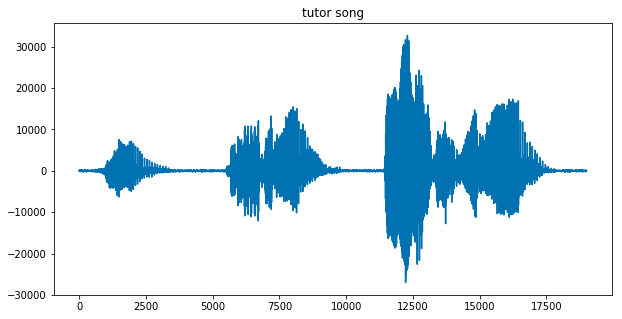

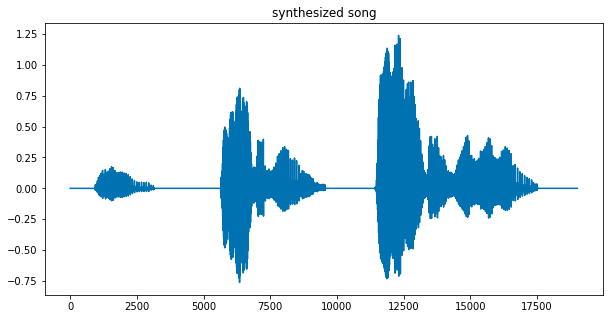

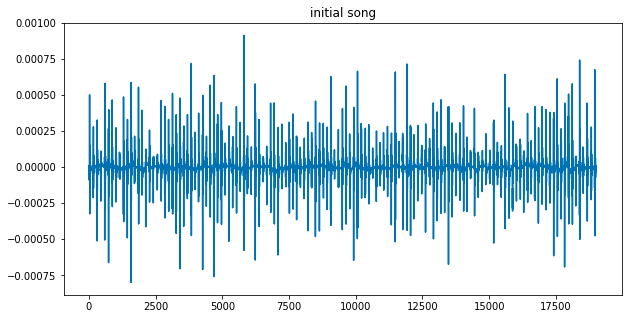

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(tutor)
plt.title("tutor song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(synth)
plt.title("synthesized song")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(song)
plt.title("initial song")
# plt.ylim(-1, 1)
plt.show()

Rq : différence des échelles des chants générées ==> voir l'impact sur les features pour voir l'importance de la normalisation

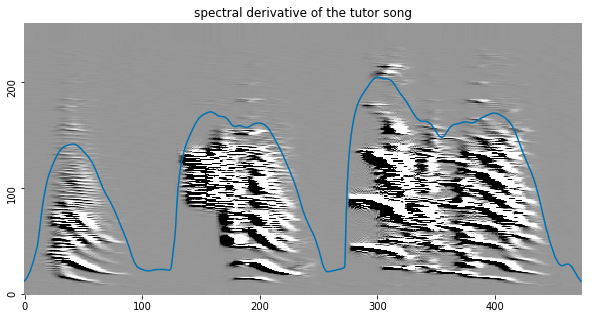

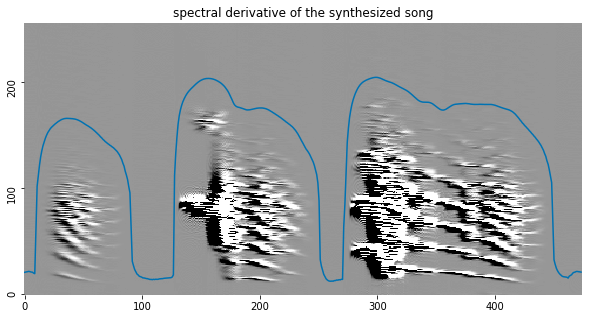

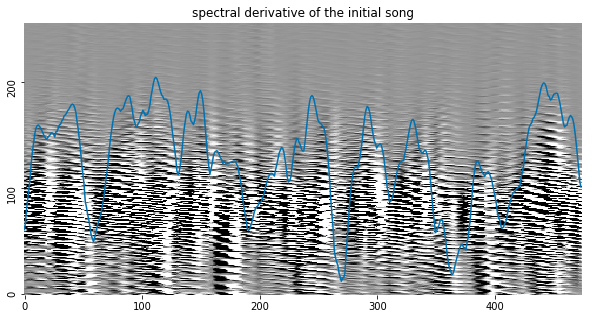

In [6]:
# Spectral derivatives
tspec = bsa.spectral_derivs(tutor, 256, 40, 1024)
sspec = bsa.spectral_derivs(synth, 256, 40, 1024)
# initial song spectral derivative
ispec = bsa.spectral_derivs(song, 256, 40, 1024)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(tspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(tutor, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the tutor song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(sspec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(synth, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the synthesized song")
plt.show(fig)

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
ax = bsa.spectral_derivs_plot(ispec, contrast=0.01, ax=ax)
bsa.plot_over_spec(bsa.song_amplitude(song, 256, 40, 1024), ax=ax)
plt.title("spectral derivative of the initial song")
plt.show(fig)

Rq : synth_song : effet de bords, plus constante en range de fréquence 0

# bsa_measure function step by step

# Features dict

In [7]:
tutor_feat = bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40)
synth_feat = bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40)
song_feat = bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40)

# Plots of features evolution during the song

In [8]:
fnames = ['fm', 'am', 'entropy', 'goodness', 'amplitude']

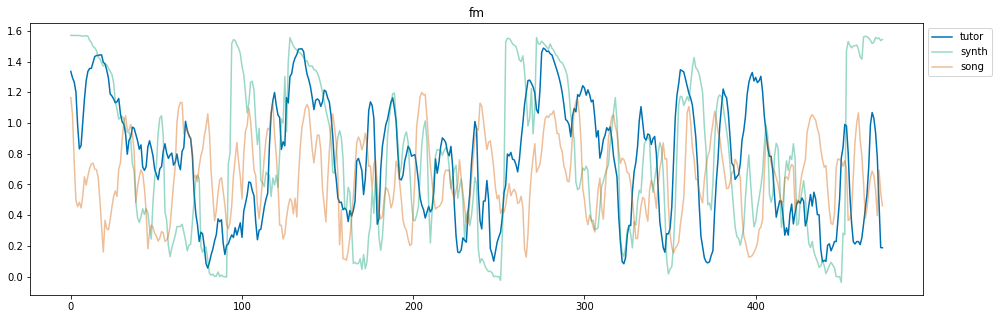

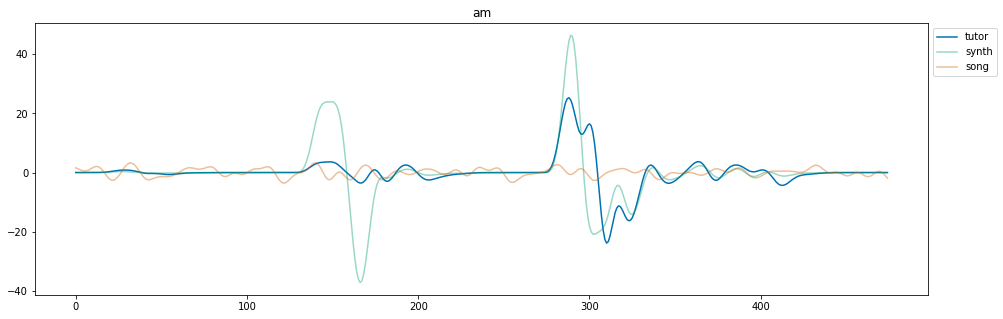

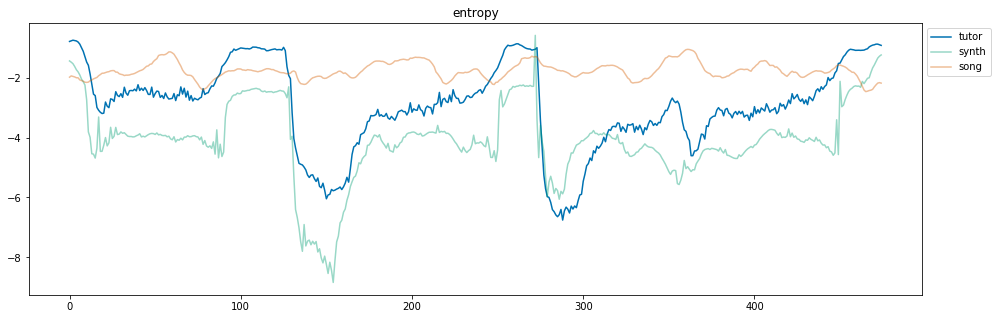

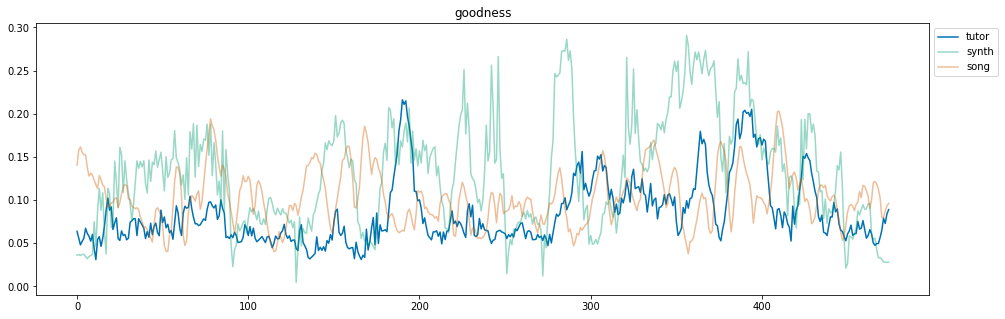

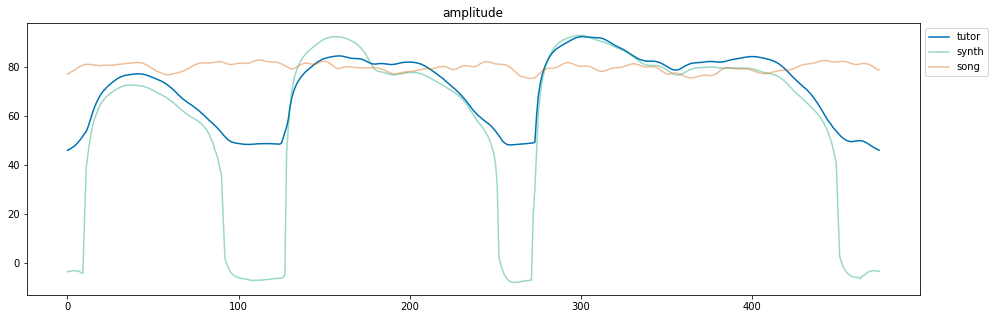

In [9]:
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

Rappel : 
- entropy haute <=> bcp de fréquences. Ex.: bruit blanc
- entropy faible <=> ~fréquence pure

Rq :

- synth : effet de bord sur toutes les features sauf am

- grosses différences en am entre tutor et synth (cf. les sons)

- grande différences de valeurs entre tutor et synth pendant les temps de silence ==> enlever ces temps de silences pour le calcul de score (ce qui est fait)

- On est sur des échelles différentes
    - fm : [0 ; 1.5]
    - am : [-50 ; 50]
    - entropy : [-8 ; 0]
    - goodness: [0 ; 0.5]
    - amplitude : [30 ; 100]

In [10]:
# min and max value for each features
for feat in fnames:
    print("***  {}  ***".format(feat))
    print("tutor: min = {}, max = {}".format(tutor_feat[feat].min(), tutor_feat[feat].max()))
    print("synth: min = {}, max = {}".format(synth_feat[feat].min(), synth_feat[feat].max()))
    print("song: min = {}, max = {}".format(song_feat[feat].min(), song_feat[feat].max()))
    print()

***  fm  ***
tutor: min = 0.05522690730850613, max = 1.4874213770860554
synth: min = -0.038051335776573846, max = 1.5702768214871816
song: min = 0.10654767776798377, max = 1.1988340115474927

***  am  ***
tutor: min = -23.85273165976408, max = 25.29098641336394
synth: min = -37.14924939411679, max = 46.374239510021944
song: min = -3.5589019483924225, max = 3.2827356588832894

***  entropy  ***
tutor: min = -6.756260656330812, max = -0.748352106572094
synth: min = -8.83925731654267, max = -0.5867612878924646
song: min = -2.46600804498364, max = -1.0540998856722457

***  goodness  ***
tutor: min = 0.031024066653813864, max = 0.21619258431686444
synth: min = 0.004649366460660536, max = 0.2908659591692414
song: min = 0.03796634391899507, max = 0.20307550634715307

***  amplitude  ***
tutor: min = 45.99364404776331, max = 92.28743861348663
synth: min = -7.910157560015758, max = 92.8203356877788
song: min = 75.20284972125044, max = 82.76798730357383



# MAD normalization

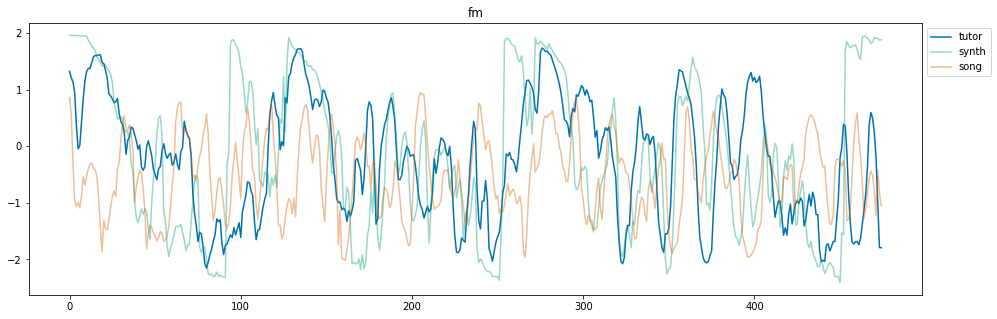

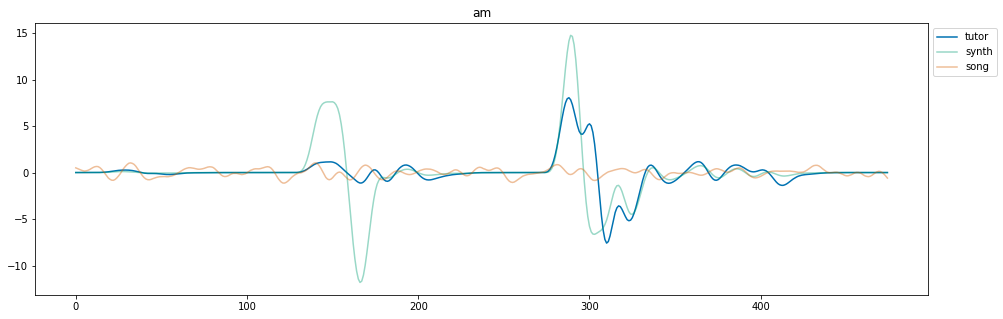

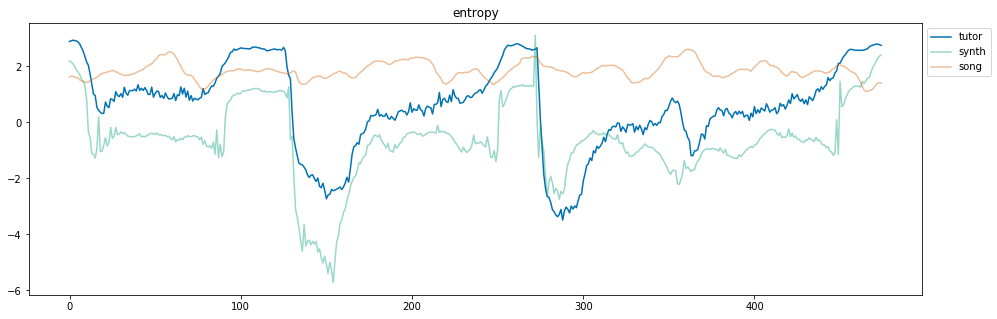

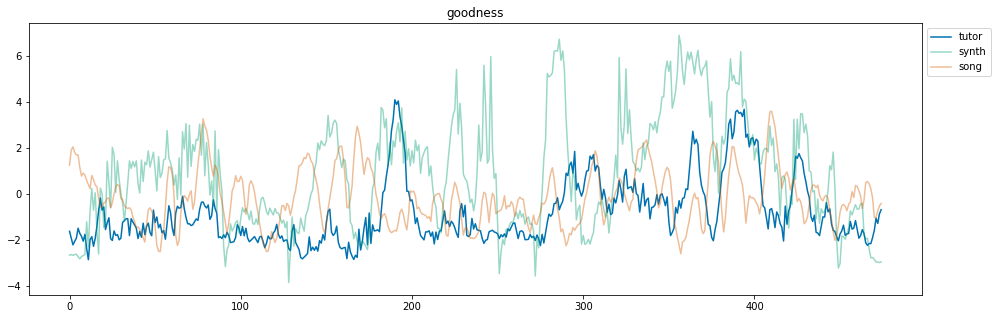

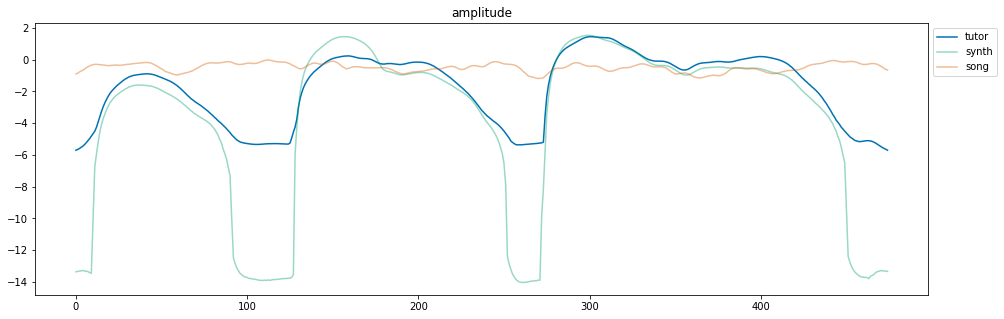

In [11]:
# MAD-NORMALIZED
tutor_feat = bsa.normalize_features(bsa.all_song_features(tutor, sr, freq_range=256, fft_size=1024, fft_step=40))
synth_feat = bsa.normalize_features(bsa.all_song_features(synth, sr, freq_range=256, fft_size=1024, fft_step=40))
song_feat = bsa.normalize_features(bsa.all_song_features(song, sr, freq_range=256, fft_size=1024, fft_step=40))
for feat in fnames:
    plt.figure(figsize=(16, 5))
    plt.plot(tutor_feat[feat], label="tutor")
    plt.plot(synth_feat[feat], alpha=0.4, label="synth")
    plt.plot(song_feat[feat], alpha=0.4, label="song")
    plt.title(feat)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")

- On est sur des échelles différentes
    - fm : [0 ; 1.5] ==> [-2.5 ; 2]
    - am : [-50 ; 50] ==> [-20 ; 20]
    - entropy : [-10 ; 0] ==> [-4 ; 3]
    - goodness: [0 ; 0.5] ==> [-4 ; 8]
    - amplitude : [30 ; 100] ==> [-10 ; 0]
    
  Conclusion : pas normalisé en [0 ; 1]

In [12]:
# min and max value for each features
for feat in fnames:
    print("***  {}  ***".format(feat))
    print("tutor: min = {}, max = {}".format(tutor_feat[feat].min(), tutor_feat[feat].max()))
    print("synht: min = {}, max = {}".format(synth_feat[feat].min(), synth_feat[feat].max()))
    print("song: min = {}, max = {}".format(song_feat[feat].min(), song_feat[feat].max()))
    print()

***  fm  ***
tutor: min = -2.155613466707142, max = 1.7348781498313464
synht: min = -2.4089996027283966, max = 1.959951223795401
song: min = -2.0162029107803994, max = 0.9509436004673253

***  am  ***
tutor: min = -7.58738002157706, max = 8.044618355867764
synht: min = -11.816835011933634, max = 14.75093588983613
song: min = -1.1321681336965699, max = 1.0440707055555882

***  entropy  ***
tutor: min = -3.489012637046665, max = 2.9332755016143417
synht: min = -5.715678478071551, max = 3.1060116192711895
song: min = 1.0971487915957385, max = 2.6064395787846393

***  goodness  ***
tutor: min = -2.85567822360283, max = 4.078209029612367
synht: min = -3.843314781829547, max = 6.8744552197214785
song: min = -2.595715199408189, max = 3.587022185965886

***  amplitude  ***
tutor: min = -5.7048746546683775, max = 1.4396904954894958
synht: min = -14.023899397416749, max = 1.5219330055564477
song: min = -1.196990285364481, max = -0.029455438980631344



# Contribution of each feature (in a vector) in the error calculation

In [13]:
# mtutor and msong are results from bsa_measure()
def err_per_feat(mtutor, msong):
    err_feats = np.zeros(mtutor.shape[1])
    for i in range(mtutor.shape[1]):
        err_feats[i] = np.sum(np.absolute(mtutor[:,i] - msong[:,i])**2)
    return err_feats

def carac_to_calculate_err_of_synth(tutor_song, synth_song, p_coefs):
    amp = bsa.song_amplitude(synth_song, 256, 40, 1024)
    sort_amp = np.sort(amp)
    sort_amp = sort_amp[len(sort_amp)//10:]
    i_max_diff = np.argmax(utils._running_mean(np.diff(sort_amp), 100))
    threshold = sort_amp[i_max_diff]
    
    return amp, threshold

# calcul a faire apres en utilisant amp et threshold: 
# err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
# score = np.linalg.norm(msynth[amp > threshold] - mtutor[amp > threshold]) / np.sum(amp > threshold) * len(amp)

In [14]:
# TESTS of the functions
coefs = {"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1}

mtutor = bsa_measure(tutor, sr, coefs)
msynth = bsa_measure(synth, sr, coefs)
msong = bsa_measure(song, sr, coefs)

# Own calculation
print("JUST FOR VERIFICATION: cmp between own calculations and model's function results")
print("err for INIT song from err per feat:", math.sqrt(np.sum(err_per_feat(mtutor, msong))))
print("sum of err per feat == err squared:", np.sum(err_per_feat(mtutor, msong)))

amp, threshold = carac_to_calculate_err_of_synth(tutor, synth, coefs)
err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
synth_score = math.sqrt(np.sum(err_per_feat_synth)) / np.sum(amp > threshold) * len(amp)

print("err for SYNTH song from err per feat:", synth_score)
print()

# Check with initial functions
song_err = error_measure(mtutor, msong)
print("Initial song error:", song_err)
print("Initial song error SQUARED:", song_err**2)

synth_err = boari_synth_song_error(tutor, synth, coefs)
print("Boari synth error:", synth_err)

JUST FOR VERIFICATION: cmp between own calculations and model's function results
err for INIT song from err per feat: 136.89172283981378
sum of err per feat == err squared: 18739.343782052394
err for SYNTH song from err per feat: 132.5961541910773

Initial song error: 136.89172283981378
Initial song error SQUARED: 18739.343782052394
Boari synth error: 132.59615419107726


In [15]:
coefs_list = [{"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1},
              {"fm": 1, "am": 1, "entropy": 5, "goodness": 1, "amplitude": 5, "pitch": 1}]

# coefs_list = [{"fm": 1, "am": 1, "entropy": 1, "goodness": 1, "amplitude": 1, "pitch": 1}]

In [16]:
fnames = ["fm", "am", "entropy", "goodness", "amplitude"]

for coefs in coefs_list:
    print("fm: {} / am: {} / entropy: {} / goodness: {} / amplitude: {}"
          .format(coefs["fm"], coefs["am"], coefs["entropy"], coefs["goodness"], coefs["amplitude"]))
    
    mtutor = bsa_measure(tutor, sr, coefs)
    msynth = bsa_measure(synth, sr, coefs)
    msong = bsa_measure(song, sr, coefs)
    
    err_feat_vect = err_per_feat(mtutor, msong)
    amp, threshold = carac_to_calculate_err_of_synth(tutor, synth, coefs)
    err_per_feat_synth = err_per_feat(mtutor[amp > threshold], msynth[amp > threshold])
    
    synth_err = boari_synth_song_error(tutor, synth, coefs)
    song_err = error_measure(mtutor, msong)
    
    print("Boari err per feat:")
    str_synth = "synth: "
    str_song = "song: "
    for i in range(len(fnames)):
        str_synth += "\t{}: {}".format(fnames[i], round(err_per_feat_synth[i],3))
        str_song += "\t{}: {}".format(fnames[i], round(err_feat_vect[i],3))
    print(str_synth)
    print(str_song)
    print()
    print("Boari synth error:", synth_err)
    print("Initial song error:", song_err)
    print()
    print("Delta:", song_err - synth_err)
    print()

fm: 1 / am: 1 / entropy: 1 / goodness: 1 / amplitude: 1
Boari err per feat:
synth: 	fm: 401.633	am: 2753.185	entropy: 951.274	goodness: 3458.346	amplitude: 956.463
song: 	fm: 803.931	am: 1534.147	entropy: 1899.821	goodness: 1947.01	amplitude: 3258.672

Boari synth error: 132.59615419107726
Initial song error: 136.89172283981378

Delta: 4.29556864873652

fm: 1 / am: 1 / entropy: 5 / goodness: 1 / amplitude: 5
Boari err per feat:
synth: 	fm: 401.633	am: 2753.185	entropy: 23781.845	goodness: 3458.346	amplitude: 23911.587
song: 	fm: 803.931	am: 1534.147	entropy: 47495.537	goodness: 1947.01	amplitude: 81466.794

Boari synth error: 289.4678320478244
Initial song error: 377.5489124819704

Delta: 88.08108043414597

